# Tutorial for generating reliability field maps and gradient flow vectors:

## Reliability Field maps:  
Field maps show the contribution of the intra (x-axis) and inter (y-axis) variation to the ICC in a two dimensional histogram.

The field maps can be created using any measurable variable, but we focus on edges from a functional connectivity matrix. For a given edge, we plot the intra- and inter-variation on the x- and y-axis respectively revealing ICC (intra- and between-variation) via diagonal lines originating from point 0,0 in a rainbow-like manner. 

## Gradient flow vectors:
Built upon the variability field map, we also utilize the variability gradient flow map (GFM) for assessing the relative impact of reliability optimizations focused on one form of variation versus the other, depending on the current balance of the intra- and inter-individual variations. This allows us to identify how and where the difference in variability between two conditions changes in an optimal or sub-optimal direction towards the highest 

The gradient vector on the field map represents the optimal direction for maximal ICC change on the respective axes of individual variability. For a given ICC change, we normalized its gradient by the contributions of individual variability as compared to the optimal direction


#### Import functions needed for field maps and gradient flow vectors

In [1]:
%matplotlib inline
import os,sys
import cifti
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import surface,plotting
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('../code')
from gradient_flow_vectors import *
from reliability_field_maps import *
from variability_utils import *

/anaconda2/envs/py36/lib/python3.6/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


#### Load surfaces to plot ICC differences and gradient flow vectors on the surface

* Put prior to surface plots

In [2]:
#######################################
# Don't need thse if brainspace works #
#######################################
# # Conte surface
# lsurf = surface.load_surf_mesh('../misc/surfaces/Conte69.L.very_inflated.10k_fs_LR.surf.gii')
# rsurf = surface.load_surf_mesh('../misc/surfaces/Conte69.R.very_inflated.10k_fs_LR.surf.gii')

# Example file to save surface plots
# plabel = '../misc/Glasser2016_labels/HCP_MMP_P210_10k.dlabel.nii'
# glasserlabel,(ax1,ax2) = cifti.read(plabel)
# numverts = glasserlabel.shape[1]

#### Load colormaps and set gradient flow vector options:

In [3]:
# Colormaps
# from variability_utils import gradientFlowCmaps,yeo_parcels

# Vector plot options:
outpath = False
vector_type = 'norm_0' # raw, norm, norm_0
alpha = 1 # plot option


## Data used:
 * Functional
     * Every edge from the upper triangle of a 360 x 360 functional connectivity matrix was used as input for the ICC model.
         * N<sub>subs</sub> x edges from upper triangle of functional connectivity matrix
     * The output arrays generated from the ICC model along with our specific data dictionary keys are listed below: 
         * ICC ('icc')
         * raw intra-individual variation ('raww')
         * raw inter-individual variation ('rawb')
         * total variation ('vartotal')
         * mask of failed edges ('totmask')
     * Also included are masked arrays which exclude failed edges. 
         * 'icc_masked', 'raww_masked', 'rawb_masked', 'vartotal_masked', 'totmask_masked'
 * Behavioral
     * N<sub>subs</sub> x 68 behavioral measures “Cognition”, “Emotion”, “Personality” (check “Motor” and “Sensory”)

## Remove masked and unused data
## Change masking to binary
## data as csv

In [ ]:
# Load Data:
data = np.load('../tutorial/example_data/tutorial_data.npy',allow_pickle=True).item()
tasks = [task for task in data.keys()]
print('Task conditions in data variable: %s' % tasks)
print('Dictionary keys within each task condition: %s' % [data_keys for data_keys in data[tasks[0]].keys()])

Task conditions in data variable: ['REST_nogsr', 'REST_gsr']
Dictionary keys within each task condition: ['rawb', 'raww', 'icc', 'vartotal', 'totmask', 'totmask_cortex', 'raww_masked', 'rawb_masked', 'icc_masked', 'vartotal_masked']


#### First obtain descriptives on GSR and no GSR ICC:

In [ ]:
for task in data.keys():
    print('%s ICC mean: %s +/- %s' % (task,np.mean(data[task]['icc_masked']),np.std(data[task]['icc_masked'])))
    print('%s Inter-individual variation mean: %s +/- %s' % (task,np.mean(data[task]['rawb_masked']),np.std(data[task]['rawb_masked'])))
    print('%s Intra-individual variation mean: %s +/- %s\n ' % (task,np.mean(data[task]['raww_masked']),np.std(data[task]['raww_masked'])))

    

REST_nogsr ICC mean: 0.3269461615406128 +/- 0.16618663921606122
REST_nogsr Inter-individual variation mean: 0.0064448203904029985 +/- 0.004434554694389156
REST_nogsr Intra-individual variation mean: 0.012462686539650639 +/- 0.004424689651843456
 
REST_gsr ICC mean: 0.33925891966189664 +/- 0.17487204079738128
REST_gsr Inter-individual variation mean: 0.00884100229180252 +/- 0.006779597231439544
REST_gsr Intra-individual variation mean: 0.015227109999291203 +/- 0.005133726686205739
 


Resting-state scans processed with GSR have greater mean ICC (0.34 +/- 0.17) compared to scans processed without GSR (0.33 +/- 0.17)

In the following, we look at how inter- and intra-individual variation contribute to ICC differences.

## Generating reliability field maps:
 * For this tutorial we compare functional connectivity from data processed with GSR and without GSR.
 * After importing libraries we load in results generated from our relibility model, most importantly ICC, raw intra-individual variation, raw inter-individual variation which we will use for both reliability field maps and gradient flow maps.
 * Light grey lines from the origin, (0,0), mark ICC values starting from 0.1 (shallowest angled bottom line) to 0.9 (steepest most left) - ICC of 0 and 1 are the X and Y axes respectively.
 * We will first create individual field maps with the function **single_fieldmap()**.
 * Overlaying the individual field maps with just the contour lines allows visual comparison of inter- and intra-individual variation on ICC (**field_map_overlay()**).
 
 
## 1. Individual fieldmaps for GSR and no GSR
 * _tasks_, _taskcolors_, _taskcmaps_ should include all conditions included in _data_
 * _taskcolors_ are individual colors for each task - can be hex or color name as set here
 * _taskcmaps_ should be color maps corresponding to each _task_ and _taskcolor_

../code/reliability_field_maps.py:59: UserWarning: linewidths is ignored by contourf
  cset = contour_func(xx1, yy1, z1scale, n_levels, **kwargs)


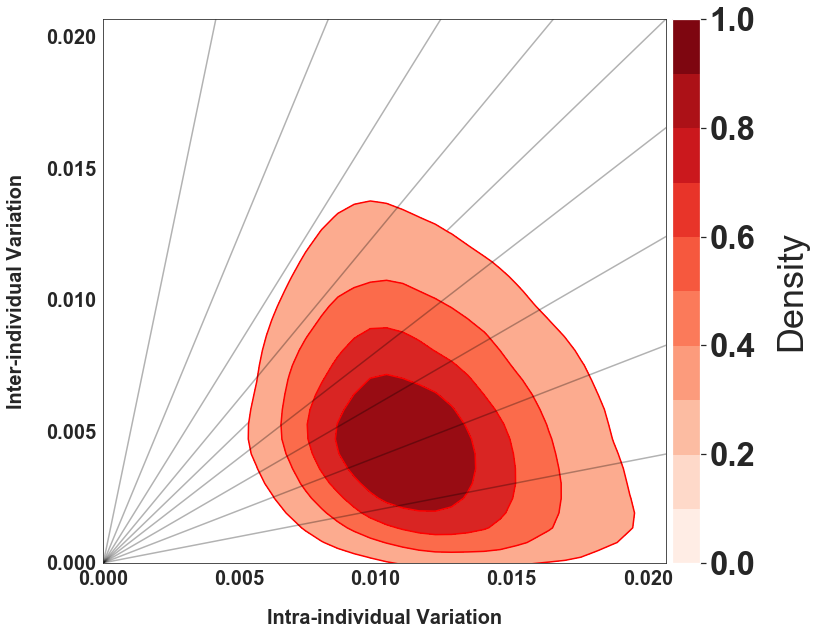

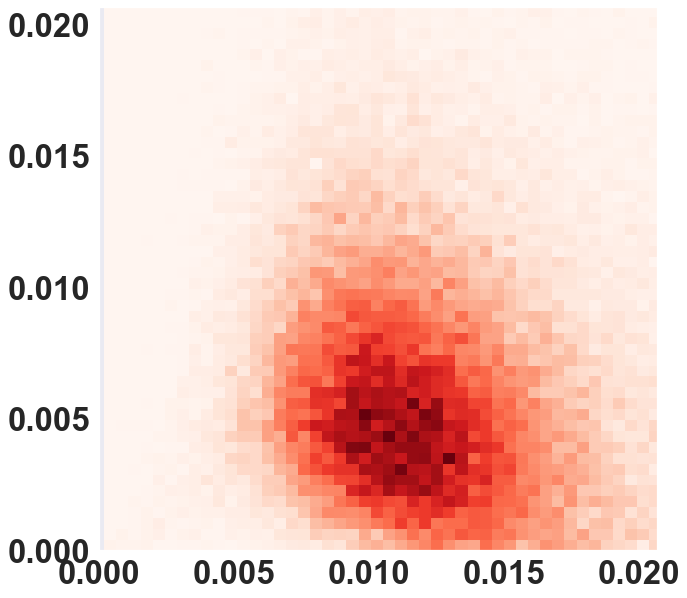

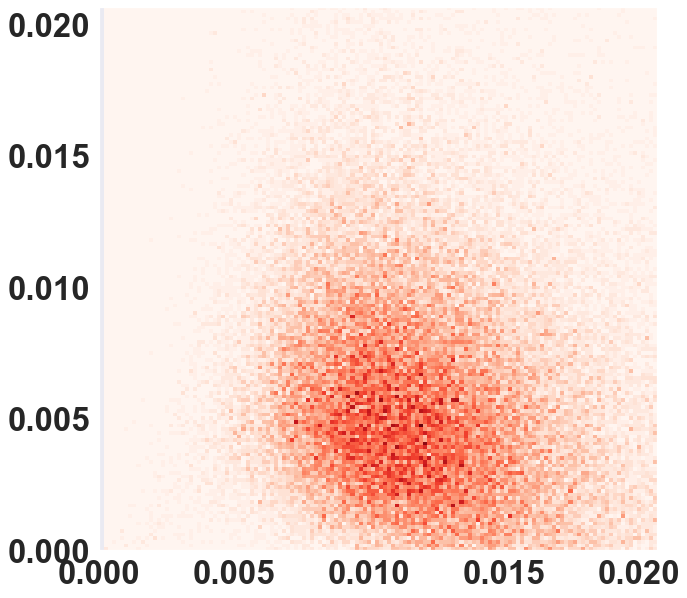

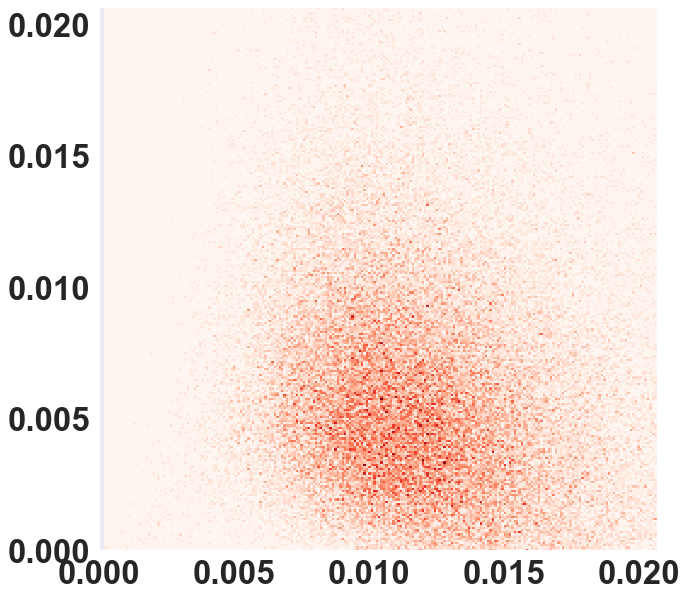

In [ ]:
# Set colormaps/colors for field map contours
tasks = ['REST_nogsr',
         'REST_gsr']
taskcolors = {'REST_gsr':'grey',
              'REST_nogsr':'red'}
taskcmaps = {'REST_gsr':'Greys',
             'REST_nogsr':'Reds'}
outpath = False # Not saving any figures for now
lines = True # Show ICC lines
alpha = 1 
thr = 0.0001 # Our threshold for which variability values to include

# Plot individual field maps:
for num,task in enumerate(['REST_nogsr','REST_gsr']):
    x = data[task]['raww_masked']
    y = data[task]['rawb_masked']
    xx1,yy1,normalized = plot_field_map(x,y,taskcolors[task],taskcmaps[task],alpha,lines,outpath,thr=0.0001,gridsize=100,
                         overlay=False,cbar_option=True,figSize=(12,10),xyLim=95,shade=True,addContourLines=True)
    
    xperc = np.percentile(x,95)
    yperc = np.percentile(y,95)
    xy_lim = np.max([xperc,yperc])
    xyVals = (0,xy_lim)
    # Small bins
    plt.figure(figsize=(10,10))
    plt.hist2d(x, y, bins=(100, 100), cmap=taskcmaps[task])
    plt.xlim([0,xyVals[1]])
    plt.ylim([0,xyVals[1]])
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.hist2d(x, y, bins=(300, 300), cmap=taskcmaps[task])
    plt.xlim([0,xyVals[1]])
    plt.ylim([0,xyVals[1]])
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.hist2d(x, y, bins=(500, 500), cmap=taskcmaps[task])
    plt.xlim([0,xyVals[1]])
    plt.ylim([0,xyVals[1]])
    plt.show()

## 2. Field map overlap for GSR and no GSR

In [ ]:
# # Not saving any figures for now.
# outpath = False
# lines = True
# alpha = 1

# # Choosing conditions to compare:
# taskcombos = [['REST_nogsr',
#                'REST_gsr']]

# plot_field_map_overlay(taskcombos,data,taskcolors,taskcmaps,alpha,lines,outpath,
#                       cbar_option=True,figSize=(12,10),xlim=(0,0.025),ylim=(0,0.025),
#                      shade=False,thr=0.0001)

## Generating gradient flow vector angular histograms:
 * Gradient flow vectors are useful understand optimality of change in variation with respect to improved reliability. Gradient flow angular histograms show the frequency of edges for each angle.
 * Gradient flow histograms are created using **gradient_flow_histogram()**.
     * 1. intra- and inter-individual variation is used to calculate standardized gradient flow vectors and the count for each angle is plotted.
     * 2. Each angle is counted and the total number is plotted according to the gradient flow circular colormap.

In [ ]:
# Paired masking:
# Input data should be masked such that each intra- and inter-individual variation value are paired between the two conditions
bothmask = np.intersect1d(data[tasks[0]]['totmask_cortex'],data[tasks[1]]['totmask_cortex'])
x0 = data[tasks[0]]['raww'][bothmask]
y0 = data[tasks[0]]['rawb'][bothmask]
icc0 = data[tasks[0]]['icc'][bothmask]
x1 = data[tasks[1]]['raww'][bothmask]
y1 = data[tasks[1]]['rawb'][bothmask]
icc1 = data[tasks[1]]['icc'][bothmask]

# Calculate vector parameters:
df = calc_icc_vectors(x0,y0,x1,y1,
                      icc0,icc1,tasks[0],tasks[1])
theta = np.array([convertAngle(df['theta0'][i],df['xdiff'][i]) for i in range(len(df['theta0']))])
theta = theta[~np.isnan(theta)]

# Gradient flow histogram plot options:
bin_threshold = 5 # degrees covered per histogram bar
outpath = False # No saving for now.
title = False # No title for now.

# Plot gradient flow histogram:
pah(theta,bin_threshold,gradientFlowCmaps['complete'],title,outpath)


## Generating surface plots for ICC differences and parcel-wise gradient flow vectors:
 * Mean of ICC differences and mean gradient flow vector direction for each parcel connectivity vector (row/column of ICC/gradient flow matrix) are plotted on the cortical surface with **plot_surface_comparisons()** .
 * **calc_icc_vectors_mean()** first calculates standardized gradient flow vectors using the parcel vector mean of inter- and intra-individual differences to yield mean gradient flow vector direction for each parcel.
     * Separate surface plots are generated for positive and negative ICC difference and gradient flow direction for clarity.
     * Due to averaging across the parcel connectivity vector, ICC difference and gradient flow direction might not have complete congruency. 

## GSR vs No GSR surface

Every 4 Surface plots in order shown (Left lateral, left medial, right lateral, right medial:
1. Positive change gradient flow vectors
2. Positive change ICC
3. Negative change gradient flow vectors
4. Negative change ICC


In [ ]:
# #############################################################
# # make positive and negative cmaps instead of changing data #
# #############################################################
# taskcombos = [['REST_gsr','REST_nogsr']]
# outpath = None
# numparcels = 1
# alpha = 1
# glasserlabel,(ax1,ax2) = cifti.read(plabel)
# surfaces = [lsurf,rsurf]
# numparcels = 1
# alpha = 1
# darkness = 0.1
# data_range = (0,360)
# cmap = rvb
# parcellation = glasserlabel
# outpath = False
# plot_surface_comparisons(taskcombos, data, parcellation, surfaces, numparcels, alpha, darkness, data_range,cmap,outpath)



While data processed without GSR has overall greater reliability compared to data processed with GSR, we can see topological differences in different brain regions as shown by surface plots showing ICC differences as well as gradient vectors. With this information different preprocessing steps can be applied when higher reliability is desired for the target region being studied. 

In [ ]:
import sys
import cifti
import matplotlib.pyplot as plt
sys.path.append('../code')
from gradient_flow_vectors import convertAngle,calc_icc_vectors
parcellation = glasserlabel
taskcombos = [['REST_gsr','REST_nogsr']]
for taskcombo in taskcombos:
    for posNeg in ['positive','negative']:
        task1 = taskcombo[0]
        task2 = taskcombo[1]
        # Vector angles:
        mask1 = data[task1]['totmask']
        mask2 = data[task2]['totmask']
        bothMask = np.intersect1d(mask1,mask2)
        icc0 = np.nanmean(array2mat(data[task1]['icc'],447),0)[0]
        icc1 = np.nanmean(array2mat(data[task2]['icc'],447),0)[0]
        x0 = np.nanmean(array2mat(data[task1]['raww'],447),0)[0]
        y0 = np.nanmean(array2mat(data[task1]['rawb'],447),0)[0]
        x1 = np.nanmean(array2mat(data[task2]['raww'],447),0)[0]
        y1 = np.nanmean(array2mat(data[task2]['rawb'],447),0)[0]
        df = calc_icc_vectors(x0,y0,x1,y1,icc0,icc1,task1,task2)

        plotname =  '%s-%s_%s_vectors' % (task2,task1,posNeg)
        converted_angles = np.array([convertAngle(df['theta0'][i],df['xdiff'][i]) for i in range(len(df['theta0']))])
        angVerts = parcel2vert(parcellation,converted_angles)
        posNegMask = parcel2vert(parcellation,icc1-icc0)
        meandICC = np.mean(posNegMask,0)
        numVertices = int(angVerts.shape[1]/2.)
        symmetric_cmap = False
        parcellation_mask = np.where(glasserlabel[0,:] == 0)[0]
        angVerts[0,parcellation_mask] = np.nan

# warm_cmap_whites,cold_cmap_whites = warm_cold_gradient_flow_cmap()
# # testarray = np.ones([1,20484]) * 300
# # testarray[0,parcellation_mask] = 45
# numVertices = int(angVerts.shape[1]/2.)
# symmetric_cmap = False
# plot_surface(angVerts,lsurf,rsurf,numVertices,data_range,warm_cmap_whites,alpha,
#                          darkness,symmetric_cmap,False,outpath,'%s-%s_%s_dICC_angle' % (task2,task1,posNeg))


In [ ]:
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
%matplotlib inline
label_text = ['Positive','Negative']
# Conte surface
lsurf = read_surface('../misc/surfaces/Conte69.L.very_inflated.10k_fs_LR.surf.gii')
rsurf = read_surface('../misc/surfaces/Conte69.R.very_inflated.10k_fs_LR.surf.gii')


In [ ]:
posmask = np.ones(angVerts.shape[1])
posmask[np.where((angVerts[0,:]<=45) | (angVerts[0,:]>=225))[0]] = np.nan
negmask = np.ones(angVerts.shape[1])
negmask[np.where((angVerts[0,:]>=45) & (angVerts[0,:]<=225))[0]] = np.nan

vertArrays = [angVerts[0,:]*posmask,angVerts[0,:]*negmask]
plot_hemispheres(lsurf, rsurf, array_name=angVerts[0,:], size=(800, 200),cmap=gradientFlowCmaps['warm'],
                color_bar=True,interactive=False,embed_nb=True,nan_color=(1,1,1,1))

In [ ]:
parcel_to_yeo_colorList = [yeo_colors[i] for i in allparcels]
plt.scatter(df['xdiff'][:360],df['ydiff'][:360],marker='o',s=20,alpha=0.7,color=parcel_to_yeo_colorList)
plt.xlim([-0.01,0.01])
plt.ylim([-0.01,0.01])

In [ ]:
mask1 = ~np.isnan(df['x_star'][:360])

# plt.scatter(df['x0'][:360],df['y0'][:360],marker='o',s=10,alpha=0.7,color='grey',zorder=2)
plt.scatter(df['x_star'][:360][mask1]+df['xdiff'][:360][mask1],
            df['y_star'][:360][mask1]+df['ydiff'][:360][mask1],
            marker='.',s=20,alpha=0.7,color=np.array(parcel_to_yeo_colorList)[mask1])
plt.xlim([0.5,0.52])
plt.ylim([0.5,0.52])
          
          